<a href="https://colab.research.google.com/github/Paul-mwaura/Gender-Based-Discrimination-NLP/blob/main/GBV_Topic_Modelling_Solution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GBV Topic Modelling Using LDA 

### Business Understanding


### Data Understanding

### Resources
* Wikipedia: [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
* Machine Learning Plus: [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
* Predictive Hacks: [LDA Topic Modelling With Gensim](https://)

### Import Libraries

In [44]:
%%capture 
pip install pyLDAvis

In [45]:
# Run in terminal or command prompt
# python3 -m spacy download en
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

#stop-words
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(nltk.corpus.stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import csv
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the Dataset

In [46]:
df = pd.read_csv("/content/GBV_data_clean_v01.csv", error_bad_lines=False)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,username,new_tweets,clean_tweets,tweets_without_stopwords,replies,retweets,likes
0,0,shaybspears,We should talk more about how this dangerous w...,we should talk more about how this dangerous w...,talk dangerous woman stalking britney sending ...,1,14,27
1,1,kaylanicole9991,"And no, getting me drunk wonât work. After w...",and no getting me drunk won t work after what...,getting drunk work happened male best friend j...,1,0,0
2,2,marge78355824,Itâs not just about seeing a random penis...,it s not just about seeing a random penis ...,seeing random penis fear every woman sexual vi...,1,0,1
3,3,explorevenango,A Franklin woman who left multiple messages in...,a franklin woman who left multiple messages in...,franklin woman left multiple messages attempt ...,0,0,0
4,4,politikscommon,I did read the details. Walker was also sue...,i did read the details walker was also sued...,read details walker also sued woman accused wa...,1,0,0


In [47]:
df['clean_tweets'][2]

'   it  s not just about seeing a random penis it  s about the fear every woman has about sexual violence it  s about the fear every human should have about sexual assault on little girls i gua'

### Data Cleaning

In [48]:
df.isna().sum()

Unnamed: 0                    0
username                      0
new_tweets                    2
clean_tweets                 23
tweets_without_stopwords    482
replies                       1
retweets                      1
likes                         1
dtype: int64

In [49]:
df.dropna(inplace=True, axis=0)
df.isna().sum()

Unnamed: 0                  0
username                    0
new_tweets                  0
clean_tweets                0
tweets_without_stopwords    0
replies                     0
retweets                    0
likes                       0
dtype: int64

In [50]:
data = pd.DataFrame(df['tweets_without_stopwords'])
data.head()

,tweets_without_stopwords
0,talk dangerous woman stalking britney sending ...
1,getting drunk work happened male best friend j...
2,seeing random penis fear every woman sexual vi...
3,franklin woman left multiple messages attempt ...
4,read details walker also sued woman accused wa...


In [51]:
data['tweets_without_stopwords'][0]

'talk dangerous woman stalking britney sending creepy emails gay demon britney reported lawyer instead issuing restraining order jamie spears made brit'

In [52]:
print(data[:1])

                            tweets_without_stopwords
0  talk dangerous woman stalking britney sending ...


### Tokenize

In [53]:
data['tokenized_tweets'] = data.apply(lambda row: nltk.word_tokenize(row['tweets_without_stopwords']), axis=1)
data.head()

,tweets_without_stopwords,tokenized_tweets
0,talk dangerous woman stalking britney sending ...,"[talk, dangerous, woman, stalking, britney, se..."
1,getting drunk work happened male best friend j...,"[getting, drunk, work, happened, male, best, f..."
2,seeing random penis fear every woman sexual vi...,"[seeing, random, penis, fear, every, woman, se..."
3,franklin woman left multiple messages attempt ...,"[franklin, woman, left, multiple, messages, at..."
4,read details walker also sued woman accused wa...,"[read, details, walker, also, sued, woman, acc..."


### Stemming
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

In [54]:
data['stemmed'] = data['tokenized_tweets'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

data.head() # Print dataframe.

,tweets_without_stopwords,tokenized_tweets,stemmed
0,talk dangerous woman stalking britney sending ...,"[talk, dangerous, woman, stalking, britney, se...","[talk, danger, woman, stalk, britney, send, cr..."
1,getting drunk work happened male best friend j...,"[getting, drunk, work, happened, male, best, f...","[get, drunk, work, happen, male, best, friend,..."
2,seeing random penis fear every woman sexual vi...,"[seeing, random, penis, fear, every, woman, se...","[see, random, peni, fear, everi, woman, sexual..."
3,franklin woman left multiple messages attempt ...,"[franklin, woman, left, multiple, messages, at...","[franklin, woman, left, multipl, messag, attem..."
4,read details walker also sued woman accused wa...,"[read, details, walker, also, sued, woman, acc...","[read, detail, walker, also, su, woman, accus,..."


### Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.
You can create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

In [55]:
vect = TfidfVectorizer(stop_words=stop_words,max_features=1000)

In [56]:
vect_text = vect.fit_transform(data['tweets_without_stopwords'])
print(vect_text)

  (0, 530)	0.31263214275557655
  (0, 623)	0.37475937020863165
  (0, 446)	0.359150252435049
  (0, 725)	0.38000375075019677
  (0, 347)	0.35169617857927526
  (0, 814)	0.26145554004437976
  (0, 965)	0.1367919611497165
  (0, 215)	0.41176458649755515
  (0, 849)	0.32880615348964776
  (1, 40)	0.1915126034739174
  (1, 895)	0.31258715750486665
  (1, 557)	0.37452154808851373
  (1, 824)	0.2188829111762232
  (1, 176)	0.29974714768481275
  (1, 335)	0.2700742476490259
  (1, 99)	0.27294034959664104
  (1, 537)	0.2540762564228144
  (1, 388)	0.26764041099618274
  (1, 973)	0.22119824660761583
  (1, 353)	0.49421933135900437
  (1, 965)	0.10384431227807862
  (2, 356)	0.1304394733658438
  (2, 513)	0.22990232240664785
  (2, 67)	0.1168545987657141
  (2, 421)	0.17390421097347344
  :	:
  (45310, 239)	0.30360315615926814
  (45310, 994)	0.3220406394901512
  (45310, 642)	0.431431738920888
  (45310, 534)	0.2694761527967481
  (45310, 956)	0.28418204266063757
  (45310, 749)	0.2694761527967481
  (45310, 867)	0.246239459

In [57]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(vect_text)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


Because we want to find out the best parametres, we use Latent Dirichlet Allocation with online variational Bayes algorithm:

In [58]:
lda = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
        evaluate_every=-1, learning_decay=0.7,
        learning_method='online', learning_offset=10.0,
        max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
        n_components=10, n_jobs=-1, perp_tol=0.1,
        random_state=100, topic_word_prior=None,
        total_samples=1000000.0, verbose=0
 )

# Create Document — Topic Matrix
lda_output = lda.fit_transform(vect_text)
print(lda_model) 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(vect_text))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vect_text),"LDA Parameters:\n")
# See model parameters
pprint(lda.get_params())

On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

### Dominant topic
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [60]:
# column names
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)

def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.030000,0.140000,0.030000,0.030000,0.030000,0.650000,9
Doc1,0.020000,0.020000,0.790000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,2
Doc2,0.030000,0.680000,0.120000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1
Doc3,0.030000,0.750000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1
Doc4,0.030000,0.200000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.600000,0.030000,8
Doc5,0.770000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0
Doc6,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.720000,0.030000,8
Doc7,0.030000,0.030000,0.340000,0.030000,0.030000,0.030000,0.430000,0.030000,0.030000,0.030000,6
Doc8,0.020000,0.020000,0.020000,0.020000,0.090000,0.020000,0.020000,0.520000,0.220000,0.020000,7
Doc9,0.030000,0.030000,0.030000,0.760000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,3


Get the top 15 keywords each topic

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vect, lda_model=lda, n_words=20):
    keywords = np.array(vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lda.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vect, lda_model=lda, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

We need to infer topics according to their key words. For example: For topic 1, people talk about "slavery", "racism", "labor", we conclude that this topic is about "racism".
Next, put the 10 topics we infered into the dataframe.

In [62]:
Topics = ["child marriage", "trafficking", 'sex trafficking',
          "stalking", "human trafficking", "drug trafficking", "sexual violence",
          "assault", "sexual violence", "gender violence"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,girls,violence,woman,assault,gun,problem,mean,give,wife,illegal,missing,women,called,needs,relationship,child marriage
Topic 1,violence,girls,human,today,little,boys,la,god,news,across,gender,girl,please,already,social,trafficking
Topic 2,marriage,gender,child,violence,im,age,girls,prostitution,family,children,legal,investigation,female,like,trans,sex trafficking
Topic 3,forced,like,violence,dont,woman,people,even,sexual,think,know,assault,parents,get,want,men,stalking
Topic 4,trafficking,discrimination,victims,support,sex,chose,rights,laws,find,something,every,fucking,fuck,envy,issues,human trafficking
Topic 5,underage,gaetz,matt,first,making,different,enough,shit,name,bad,time,married,child,two,talk,drug trafficking
Topic 6,assault,woman,charged,new,man,sexual,police,via,arrested,violence,involved,charges,crime,states,choose,sexual violence
Topic 7,trafficking,sex,girl,trump,young,epstein,without,maybe,biden,trafficked,party,long,maxwell,identity,court,assault
Topic 8,girls,woman,accused,old,stalking,year,real,exploitation,de,years,black,labor,using,death,person,sexual violence
Topic 9,girls,human,child,women,marriages,violence,state,love,sex,children,anything,always,slavery,young,lol,gender violence


### Predict Topics using LDA model
Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.
For our case, the order of transformations is:
sent_to_words() –> Stemming() –> vectorizer.transform() –> best_lda_model.transform()
You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function.

In [ ]:
%%capture
import gensim
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform
X = count_vect.fit_transform(df.tweets_without_stopwords)
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
 
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
 
 
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
 
ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id_map, passes=2,
                                               random_state=5, num_topics=10, workers=2)



In [ ]:
for idx, topic in ldamodel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

### Topic Distribution

In [ ]:
def topic_distribution(string_input):
    string_input = [string_input]
    # Fit and transform
    X = vect.transform(string_input)
 
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
 
    output = list(ldamodel[corpus])[0]
 
    return output
  
my_document = "its about the fear every woman has about sexual violence"
 
topic_distribution(my_document)

### Cluster documents that share similar topics and plot
You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().
Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.
We now have the cluster number. But we also need the X and Y columns to draw the plot.
For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [37]:
%%capture
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

In [38]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.6   0.21  0.23  0.37  0.34  0.31  0.29  0.15  0.17  0.24]
 [ 0.79 -0.08 -0.1  -0.32 -0.28 -0.22 -0.34 -0.06 -0.05 -0.13]]
Perc of Variance Explained: 
 [0.02 0.23]


We have the X, Y and the cluster number for each document.
Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Segregation of Topic Clusters')

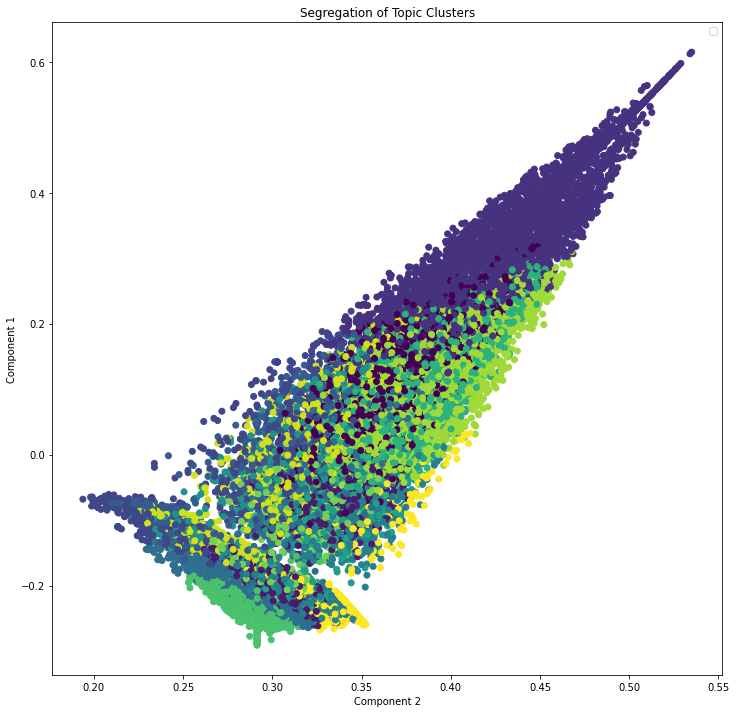

In [39]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.legend()
plt.title("Segregation of Topic Clusters", )

Get similar documents for any given piece of text?
Once you know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance.
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, vect_text, vect)
vis

Get similar documents:

In [ ]:
mytext = [“I think they are really helpful”]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print(‘\n’, docs[0][:500])
print()